Do basic notebook starting stuff
--

In [ ]:
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB)
    return [disk, halo, bulge]

def actions(s, sf, pot_galpy, IDs, R0_kpc, v0_kms):
    # create a mask of all GCs which survive until the end
    gcmask = np.isin(s.id, IDs)

    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    # convert physical to galpy units by dividing by REF vals
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / R0_kpc, vR_kms / v0_kms, vphi_kms / v0_kms, z_kpc / R0_kpc, vz_kms / v0_kms

    # estimate Delta of the Staeckel potential
    delta = 0.45
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
    # CHECK HOW BIG INFLUENCE OF DELTA IS

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    
    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy)
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * R0_kpc * v0_kms, lz_galpy * R0_kpc * v0_kms, jz_galpy * R0_kpc * v0_kms

    return(jR_kpckms, lz_kpckms, jz_kpckms)

In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [3]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from IPython.display import Image, display

import corner

import datetime
import random

import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.colors import LogNorm


import datetime

cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))

%matplotlib inline

In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"

    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [5]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____


Action evolution parameters
---

- IDlist (somehow.... find where dwarf (67 für den Anfangs) merges)
- startnr
- fit routine = emcxee 1 (in v0.1; more maybe in v0.2)
- delta fix or calculation
- figure (with labels, range, title etc predefined)
- in v0.2 possibility for wrong potential


Get IDs of merged stars
---


In [6]:
ids_merger = np.loadtxt(filedir + 'surviving_ids_snapshot_73_sh_1.txt')
mergersnap = str(104)

In [7]:
part_num = 500
rand_samp = np.array(random.sample(list(enumerate(ids_merger)), part_num))
rand_ind = rand_samp[:,0].astype(int)
IDS = rand_samp[:, 1]

IDS = ids_merger


Load potential parameters, setup potential, calculate actions and save them
---

In [8]:
# load fitted potential parameters

# startnr is number of first snapshot to calculate its actions (of the GCs with merger IDs)
startnr = 69 # worked for the first time in 93
# endnumber is last snapshot plus 1 (since I use range function)
endnr = 128 #int(np.max(snapnr) + 1) 
# NRSNAPSHOTS USELESS ATM
# nrsnapshots = int(endnr-startnr)

halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"
    
    
calc_Actions = True
loadfromfile = True
true_fit = 1
if calc_Actions == True:
    if loadfromfile == True:
        for snap_number in range(startnr, endnr, 1):

        #### loop over snaps before here 
            snapnr, R0_kpc, v0_kms, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc, v0_MND_kms, v0_HB_kms, v0_NFWH_kms = np.loadtxt(filedir + 'potential_params/pot_snap_' + str(snap_number))

            n_MND       = v0_MND_kms**2  / v0_kms**2
            n_HB        = v0_HB_kms**2   / v0_kms**2
            n_NFWH      = v0_NFWH_kms**2 / v0_kms**2

            print(snapnr, R0_kpc, v0_kms, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc, n_MND, n_HB, n_NFWH)
            # make index starting from 0 for potential parameters
            """
            if true_fit == True:    
                print('first ii')
                ii = snapnr.tolist().index(snap_number)
                title = 'actions_merger_' + mergersnap + '_' + str(len(IDS)) +'_parts_snap_' + str(snap_number) + '_nonsmoothed_pot_params.txt'
            elif smooth_fit == True:
                print('second ii')
                ii = int(snap_number - 7)
                title = 'actions_merger_' + mergersnap + '_' + str(len(IDS)) +'_parts_snap_' + str(snap_number) + '_smoothed_pot_params_w_' + str(jj) + '_polys.txt'
            else:
                ii = snap_number
                print('Check snap index!')
                title = 'actions_merger_' + mergersnap + '_' + str(len(IDS)) +'_parts_snap_' + str(snap_number) + '_some_pot_params.txt'
            """
            title = 'actions_snap' + str(snap_number)
            print("snapnr: {0}".format(snap_number))
            print(datetime.datetime.now().time())
            s1, sf1 = eat_snap_and_fof(level, halo_number, snap_number, snappath, loadonlytype=[4], 
                haloid=0, galradfac=0.1, verbose=False) 

            # Clean negative and zero values of gmet to avoid RuntimeErrors
            # later on (e.g. dividing by zero)
            s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 ) 

            # create masks for merged stars according to their IDs to get their positions
            gcmask = np.isin(s1.id, IDS)
            print(np.sum(gcmask))
            outids = s1.id[gcmask]
            # PROBABLY DO NOT NEED THESE VALUES
            (x1_merg_kpc, y1_merg_kpc, z1_merg_kpc), (vx1_merg_kms, vy1_merg_kms, vz1_merg_kms), rxyz1_merg_kpc, rxy1_merg_kpc = get_cartesian_vectors(s1, sf1, gcmask)

            # set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
            #pot_galpy = setup_galpy_potential(a_MND_kpc[ii], b_MND_kpc[ii], a_NFWH_kpc[ii], a_HB_kpc[ii], n_MND[ii], n_NFWH[ii], n_HB[ii])
            try:
                pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
            except:
                print("no actions for snap " + str(snap_number))
                continue
            # this would mean that there are no merged GCs
            if np.sum(gcmask) == 0:
                continue

            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s1, sf1, gcmask)
            # convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
            #R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / v0_kms[ii], vphi_kms / v0_kms[ii], z_kpc / _REFR0_kpc, vz_kms / v0_kms[ii]
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / v0_kms, vphi_kms / v0_kms, z_kpc / _REFR0_kpc, vz_kms / v0_kms

            # estimate Delta of the Staeckel potential
            delta = 0.45
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
            # CHECK HOW BIG INFLUENCE OF DELTA IS


            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # set up condition to which actiosn of which GCs should be calculated (right now within 2 Galrad)
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= (2000. * s1.galrad))

            # calculate actions (in galpy units) & convert them to physical units

            #_REFV0_kms = v0_kms[ii]
            _REFV0_kms = v0_kms

            jR_galpy, lz_galpy, jz_galpy, r_kpc = np.zeros(len(IDS)), np.zeros(len(IDS)), np.zeros(len(IDS)), np.zeros(len(IDS))
            savedids = np.zeros(len(IDS))
            ids_notworking = []
            for test_i, item in enumerate(IDS):
                if (test_i % 1000) == 0:
                    print(datetime.datetime.now().time())
                    print(test_i)
                if np.sum(np.isin(r_condition, test_i)):
                    try: 
                        jR_galpy[test_i], lz_galpy[test_i], jz_galpy[test_i] = aAS(R_galpy[test_i], vR_galpy[test_i], vT_galpy[test_i], z_galpy[test_i], vz_galpy[test_i])
                        r_kpc[test_i] = np.sqrt(R_kpc[test_i]**2 + z_kpc[test_i]**2)
                        savedids[test_i] = item
                    except(ValueError, UnboundError):
                        ids_notworking.append(item)
                        continue
            print('numbers of GCs wo actions:', len(ids_notworking))
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # just pick result values of particles of which I actually could calculate actions
            survivor_id_mask = np.isin(IDS, savedids)
            jR_kpckms, lz_kpckms, jz_kpckms = jR_kpckms[survivor_id_mask], lz_kpckms[survivor_id_mask], jz_kpckms[survivor_id_mask]
            r_kpc = r_kpc[survivor_id_mask]
            survivor_ids = IDS[survivor_id_mask]

            # save data: ID, r [kpc], actions (physical units)
            np.savetxt(filedir + title, (survivor_ids, r_kpc, jR_kpckms, lz_kpckms, jz_kpckms), fmt='%.18f', header='ID\tr [kpc]\tjR [kpc km/s]\tlz [kpc km/s]\tjz [kpc km/s]')





69.0 3.91875927647 152.853095911 0.433255945531 1.06335231787 1.78499722424 9.45617105254 0.142533146377 0.318331733635 0.539135119988
snapnr: 69
13:28:34.591402
[ 14.12320042  13.61969185  14.55005264]
Found 458329 stars.
Rotated pos.
Rotated vel.
7521
13:28:49.782681
0
13:28:49.843021
1000
13:28:49.901320
2000
13:28:49.959391
3000
13:28:50.022970
4000
13:28:50.082074
5000
13:28:50.141122
6000
13:28:50.200713
7000
13:28:50.262878
8000
13:28:50.323076
9000
numbers of GCs wo actions: 0
70.0 4.0271366636 155.666843986 0.102858867268 1.3612953971 2.02286546294 8.99700564025 0.125012507037 0.315293629772 0.559693863191
snapnr: 70
13:28:50.383929
[ 14.46787739  13.95026779  14.91678429]
Found 483558 stars.
Rotated pos.
Rotated vel.
8052
13:29:05.798337
0
13:29:05.863319
1000
13:29:05.921677
2000
13:29:05.981858
3000
13:29:06.044540
4000
13:29:06.104487
5000
13:29:06.166312
6000
13:29:06.227612
7000
13:29:06.290003
8000
13:29:06.349337
9000
numbers of GCs wo actions: 0
71.0 4.28012659152 163

13:33:41.388746
3000
13:33:41.428901
4000
13:33:41.468653
5000
13:33:41.508792
6000
13:33:41.548785
7000
13:33:41.593623
8000
13:33:41.633495
9000
numbers of GCs wo actions: 0
90.0 5.98808427652 186.864445468 0.553278736713 1.8552719545 1.73987730502 28.2732029954 0.332168553407 0.345768288983 0.32206315761
snapnr: 90
13:33:41.681602
[ 21.11937714  20.39230919  22.20462799]
Found 1227647 stars.
Rotated pos.
Rotated vel.
9785
13:34:01.124855
0
13:34:01.542314
1000
13:34:01.582618
2000
13:34:01.622870
3000
13:34:01.663099
4000
13:34:01.703021
5000
13:34:01.742961
6000
13:34:01.783297
7000
13:34:01.823456
8000
13:34:01.862764
9000
numbers of GCs wo actions: 0
91.0 6.05350087086 188.841148688 1.44312486588 0.906438073458 1.77493038256 28.1949477892 0.336957532946 0.338924798308 0.324117668746
snapnr: 91
13:34:01.906945
[ 21.42389488  20.68611908  22.54693604]
Found 1255435 stars.
Rotated pos.
Rotated vel.
9785
13:34:21.047956
0
13:34:21.229329
1000
13:34:21.268993
2000
13:34:21.308920
3000

numbers of GCs wo actions: 0
107.0 7.19547818104 201.427730482 1.9715961627 1.3244617468 1.63785416611 31.1079961178 0.325277424724 0.291470096084 0.383252479192
snapnr: 107
13:58:27.131682
[ 26.97145081  25.98770905  28.78736305]
Found 1562371 stars.
Rotated pos.
Rotated vel.
9785
13:58:47.668508
0
13:59:34.100061
1000
14:00:02.714830
2000
14:00:11.477532
3000
14:00:14.245366
4000
14:00:14.820393
5000
14:00:15.827805
6000
14:00:31.634046
7000
14:01:12.936660
8000
14:01:50.707485
9000
numbers of GCs wo actions: 0
108.0 7.23544557889 198.340934057 1.043240325 0.19416149813 2.2293392723 44.3912328785 0.431363111929 0.279092307162 0.289544580909
snapnr: 108
14:02:18.074449
[ 27.23214722  26.23708725  29.08192825]
Found 1625123 stars.
Rotated pos.
Rotated vel.
9785
14:02:38.618498
0
14:03:26.986078
1000
14:04:13.431768
2000
14:05:00.053702
3000
14:05:38.912280
4000
14:06:14.214491
5000
14:06:36.599751
6000
14:06:56.781071
7000
14:07:04.739055
8000
14:07:06.825402
9000
numbers of GCs wo act

[ 33.61259842  32.37949753  36.36141205]
Found 1769475 stars.
Rotated pos.
Rotated vel.
9785
15:01:32.260106
0
15:02:18.627305
1000
15:03:04.983043
2000
15:03:47.770535
3000
15:04:05.451663
4000
15:04:28.367227
5000
15:04:30.097135
6000
15:04:42.498540
7000
15:04:51.047905
8000
15:04:59.944085
9000
numbers of GCs wo actions: 0
126.0 7.99883802732 222.144054257 3.71735517696 0.553216963203 1.91292615734 25.0267251002 0.235253423842 0.240049794077 0.524696782081
snapnr: 126
15:05:00.094150
[ 34.09642792  32.84707642  36.91917419]
Found 1774142 stars.
Rotated pos.
Rotated vel.
9785
15:09:17.016913
0
15:10:04.117314
1000
15:10:51.351454
2000
15:11:28.406840
3000
15:12:01.008029
4000
15:12:22.419807
5000
15:12:33.449132
6000
15:12:41.419452
7000
15:12:50.990332
8000
15:12:58.359251
9000
numbers of GCs wo actions: 0
127.0 8.02852213383 220.724646624 2.96507719743 1.63627757204 1.71545528287 26.0152749345 0.226318825084 0.25400087805 0.519680296866
snapnr: 127
15:12:58.573145
[ 34.42281723  3

to read in these files use: 

(in a loop replace 93 by snapnr then you don't have to extract it from the string adn can loop over all the files)

infile = '/home/extmilan/masterthesis/files/actions_snap_93_nonsmoothed_pot_params.txt'

ids, r, jr, jphi, jz = np.loadtxt('/home/extmilan/masterthesis/files/actions_snap_93_nonsmoothed_pot_params.txt')

snapshot = int(infile[(infile.find('snap_') + 5):].split('_')[0])

ids = np.array(ids, dtype=int)
 

70
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/extmilan/masterthesis/files/actions_snap70"
  

71
72
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/extmilan/masterthesis/files/actions_snap72"
  

73
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/extmilan/masterthesis/files/actions_snap73"
  

74
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/extmilan/masterthesis/files/actions_snap74"
  

75
76
77
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/home/extmilan/masterthesis/files/actions_snap77"
  

78
79
80
81
82
83
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: lo

ValueError: values must all be positive

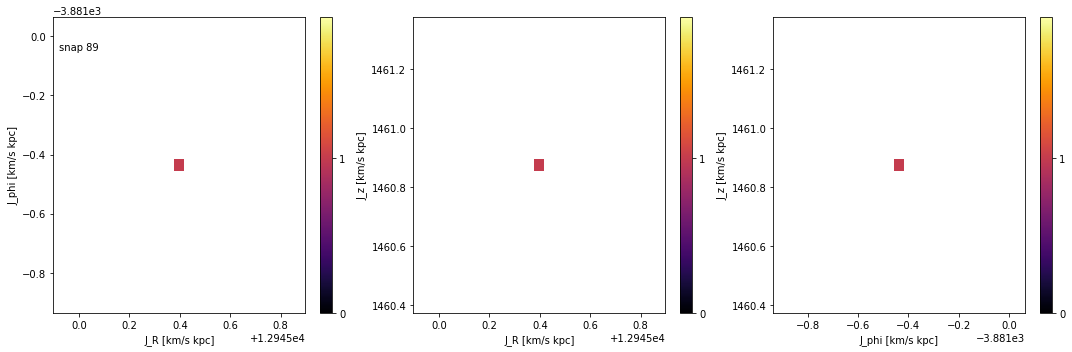

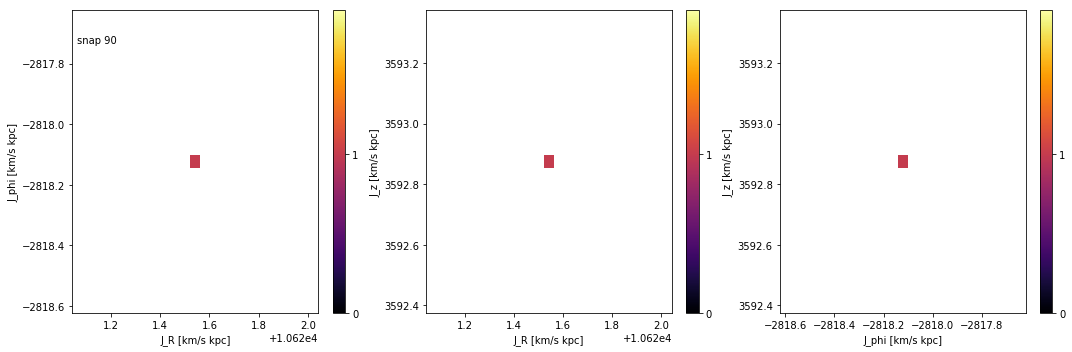

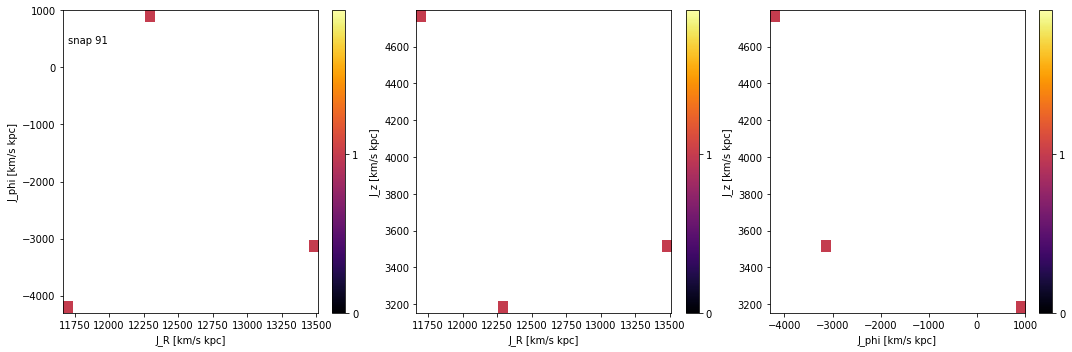

ValueError: values must all be positive

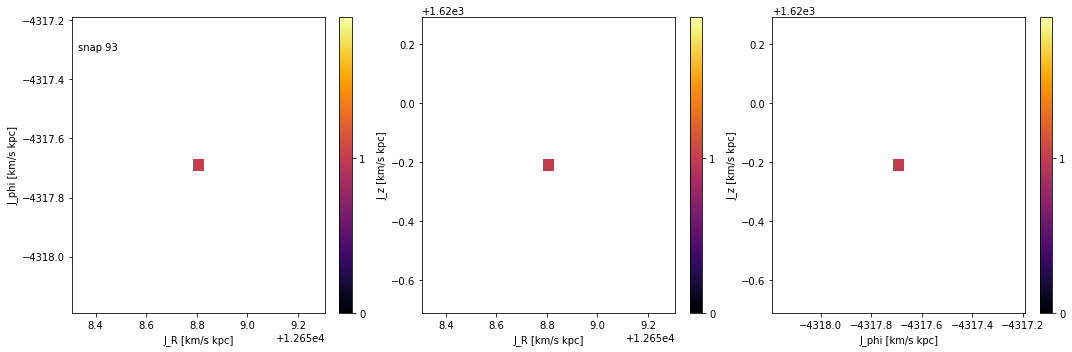

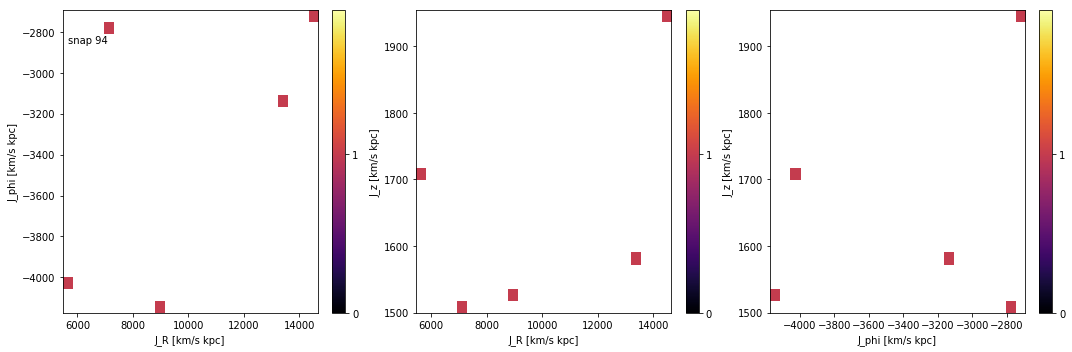

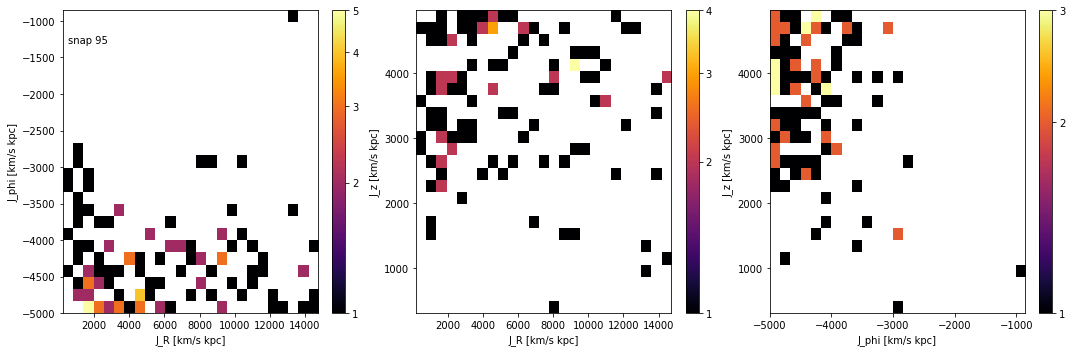

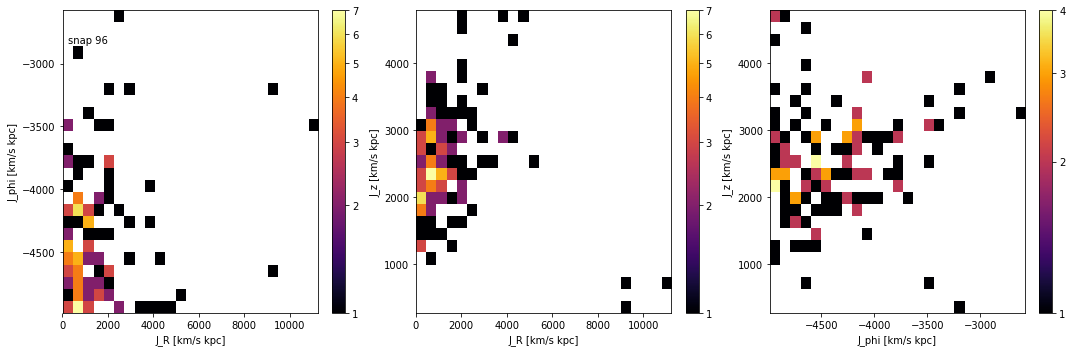

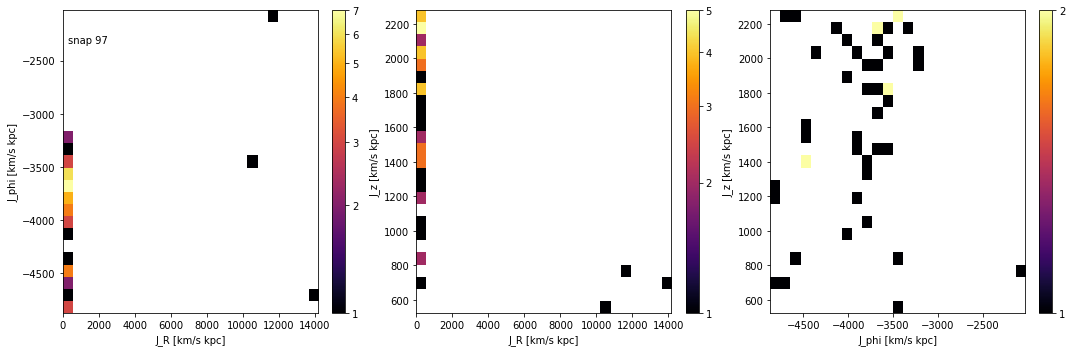

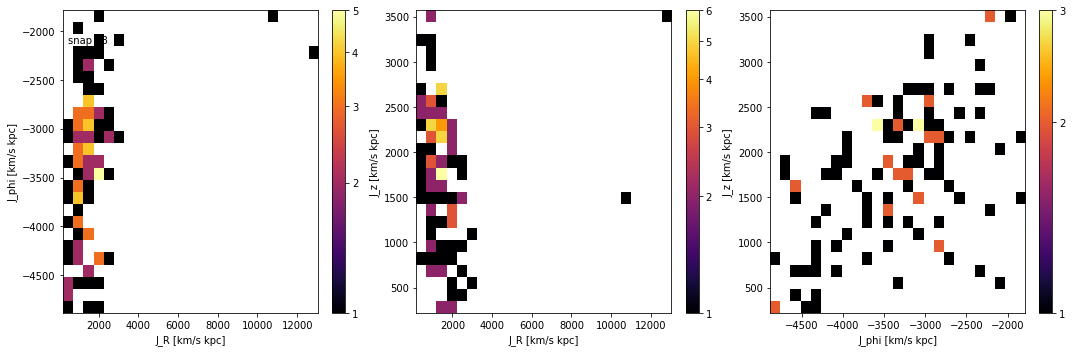

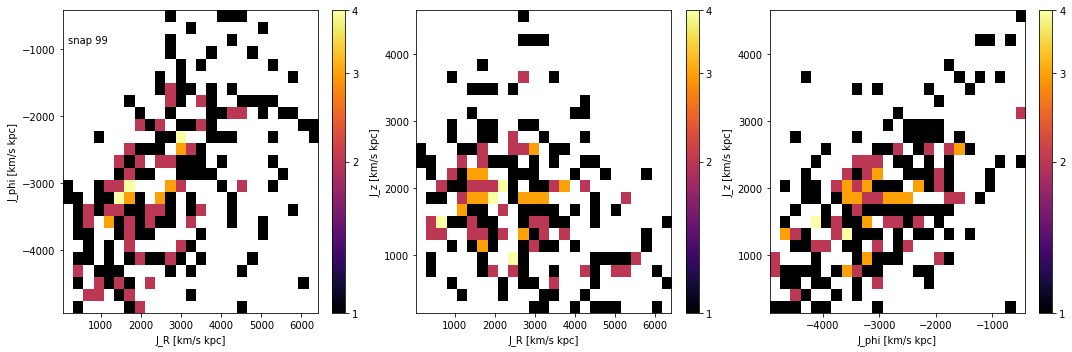

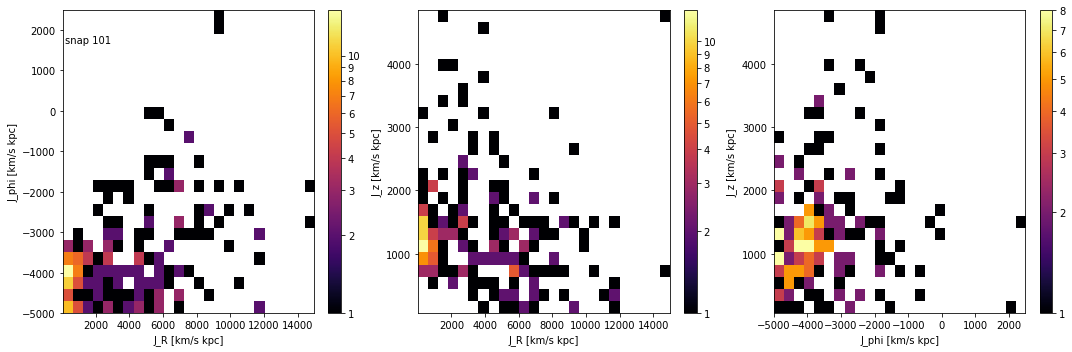

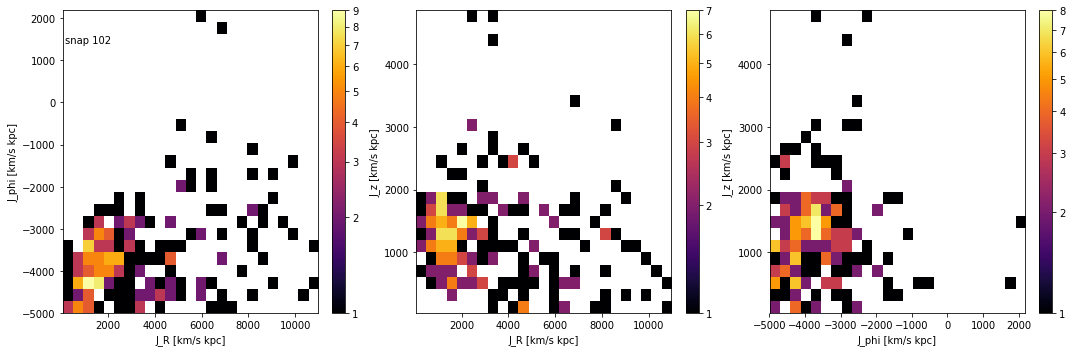

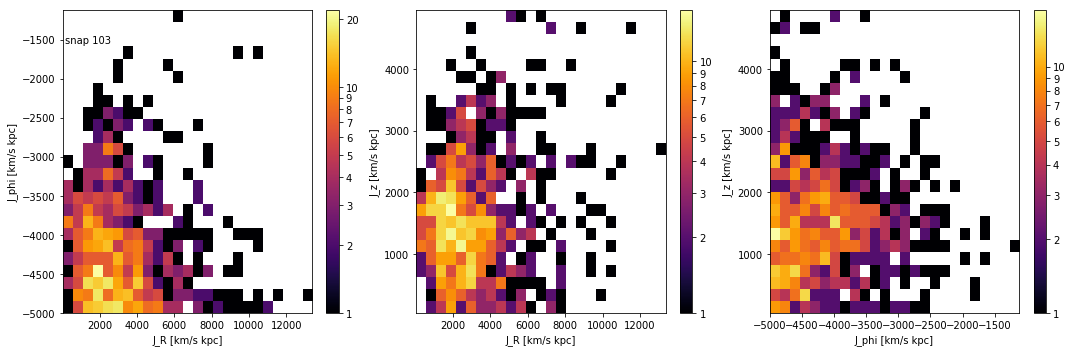

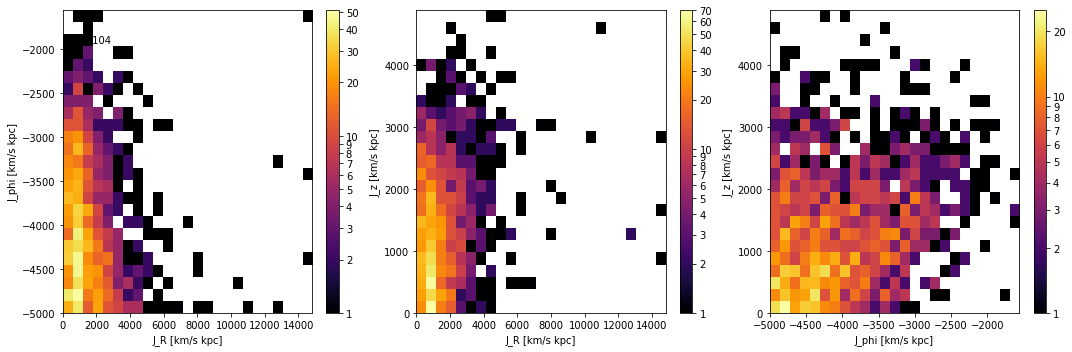

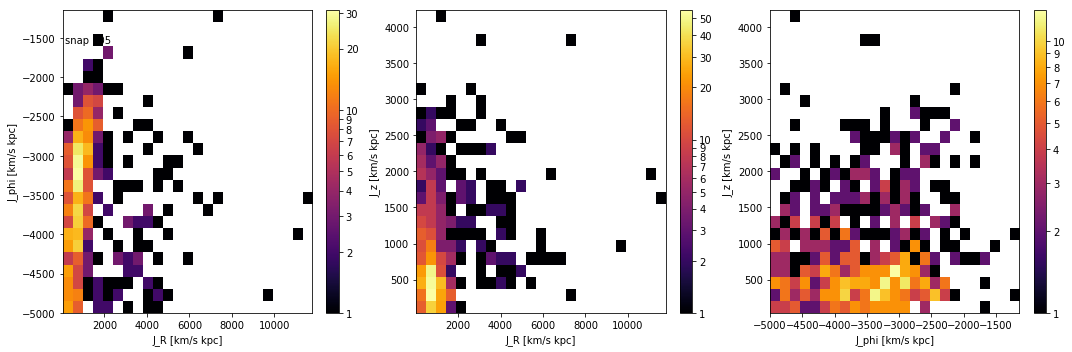

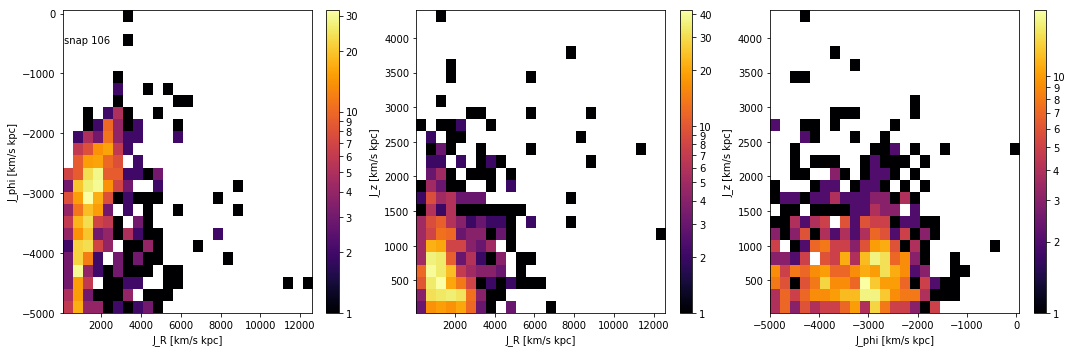

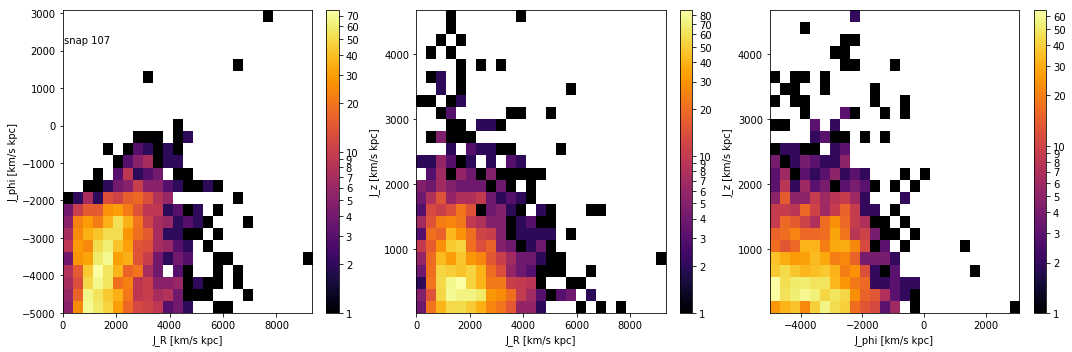

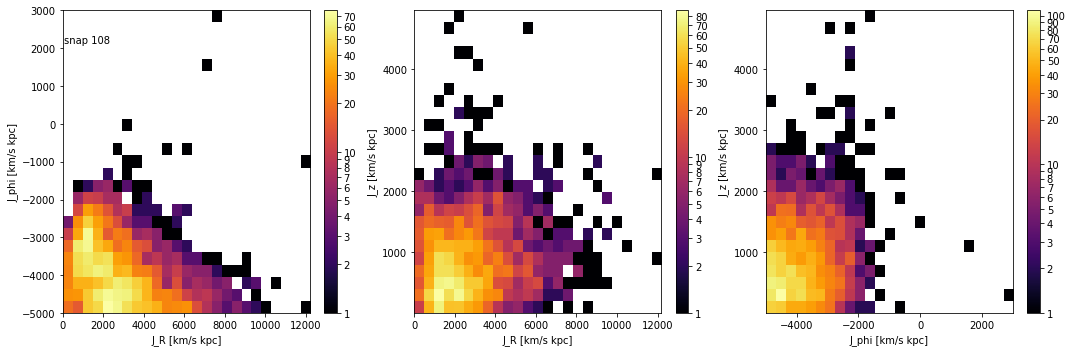

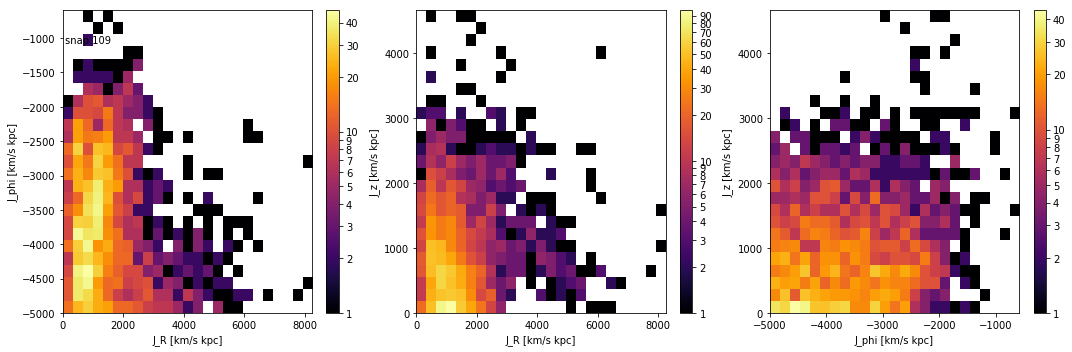

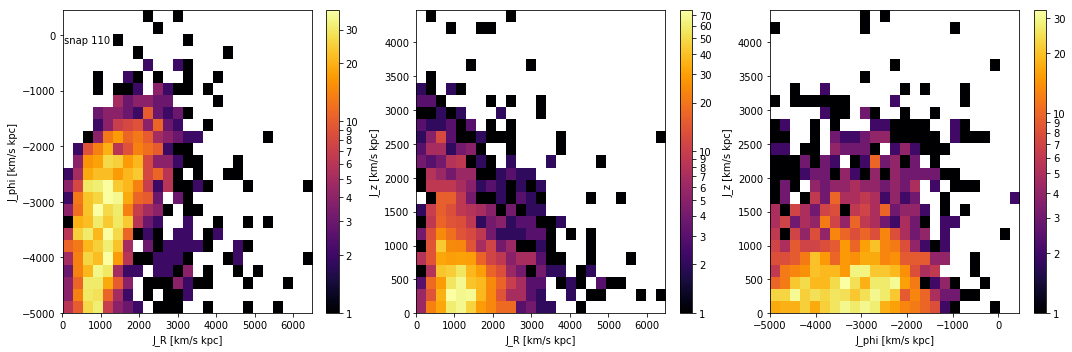

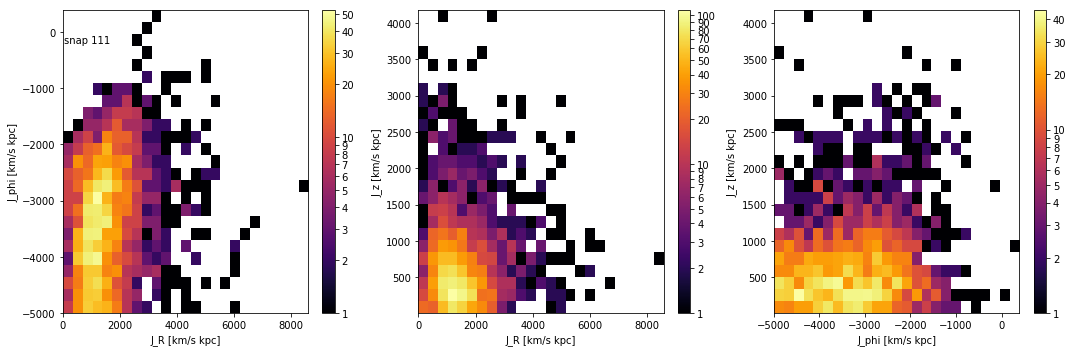

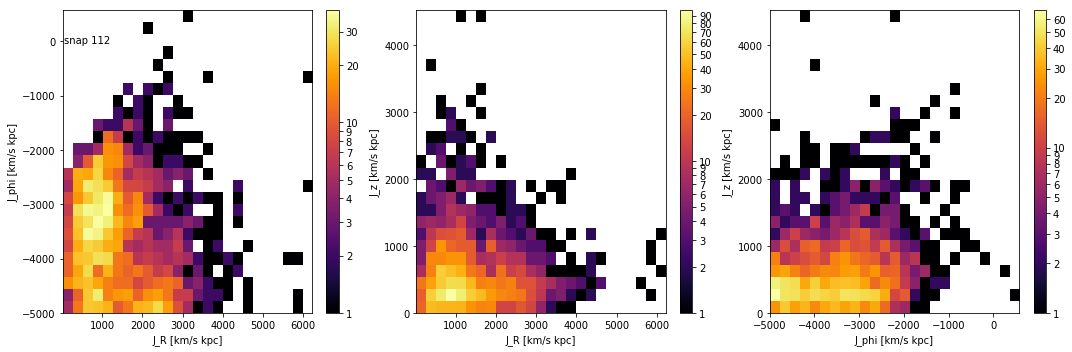

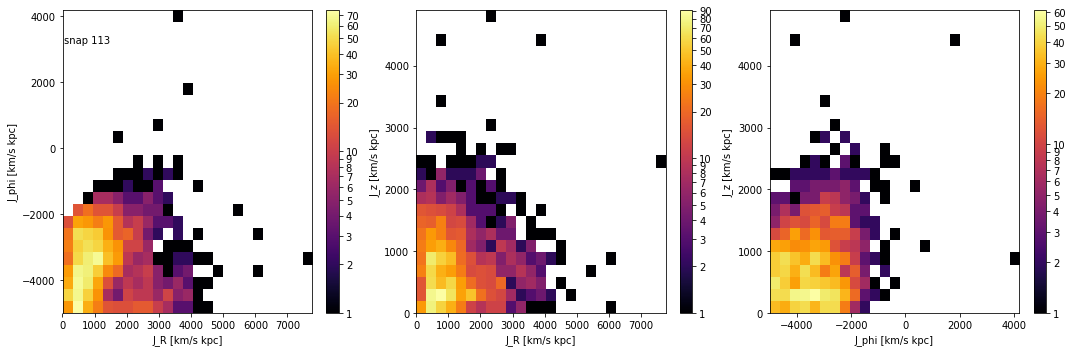

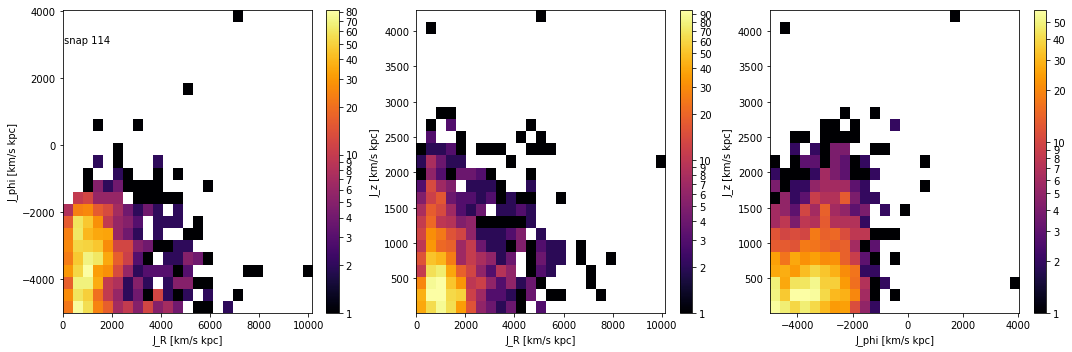

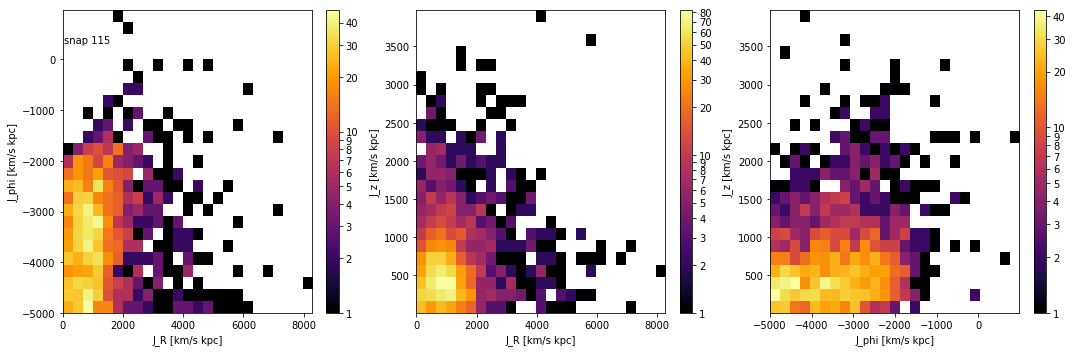

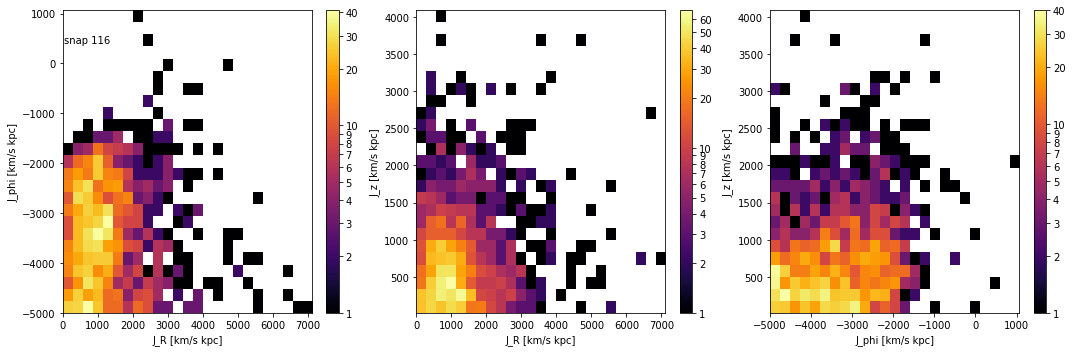

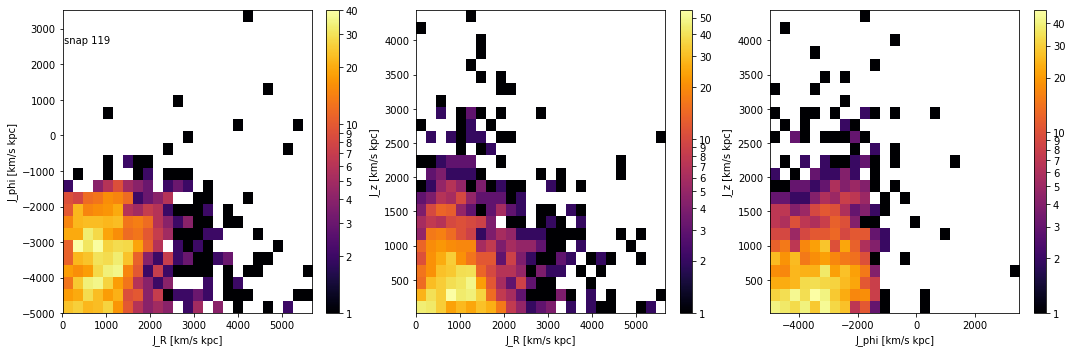

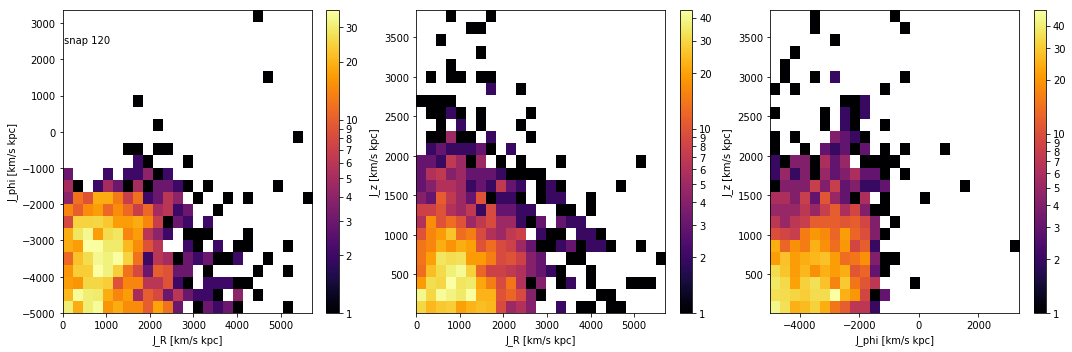

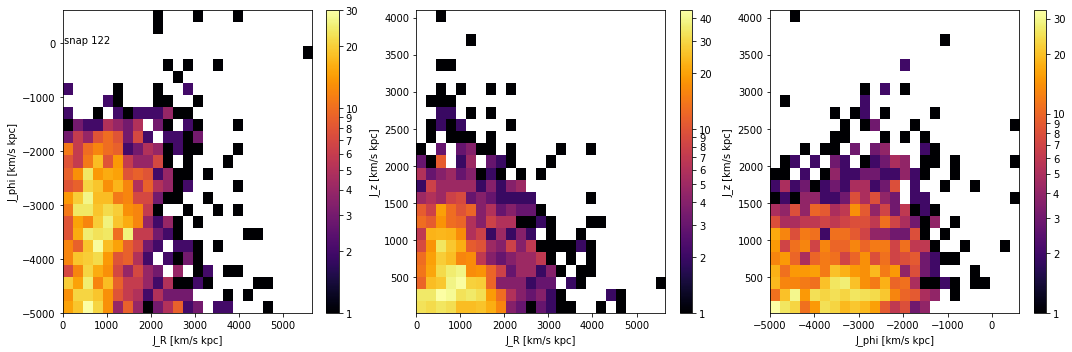

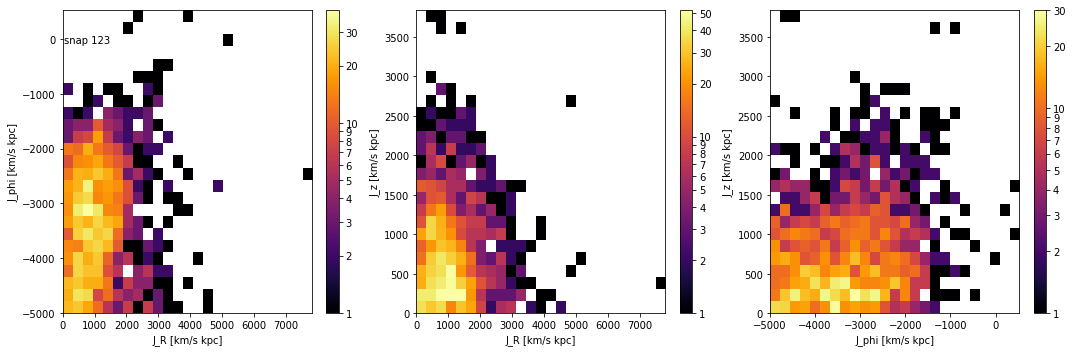

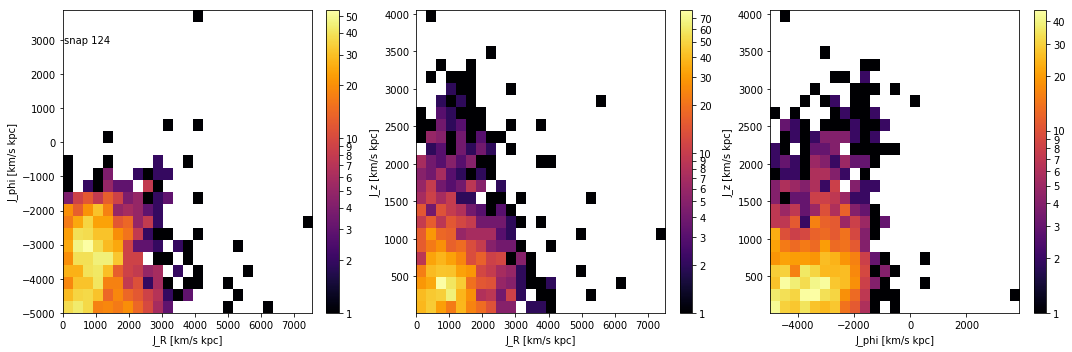

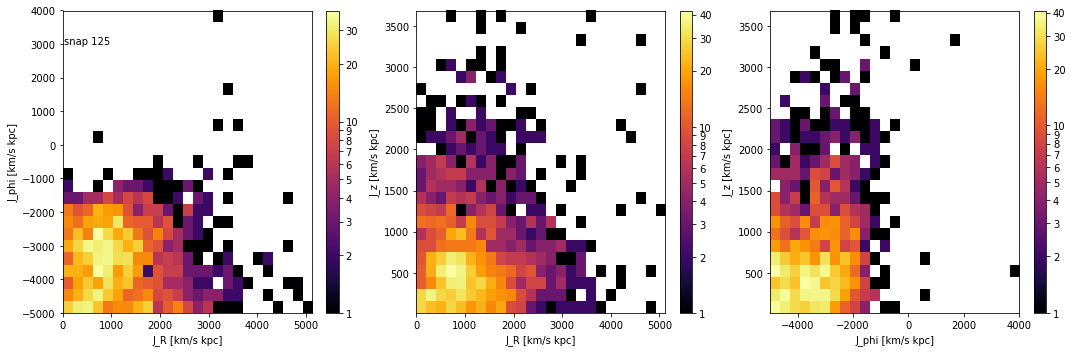

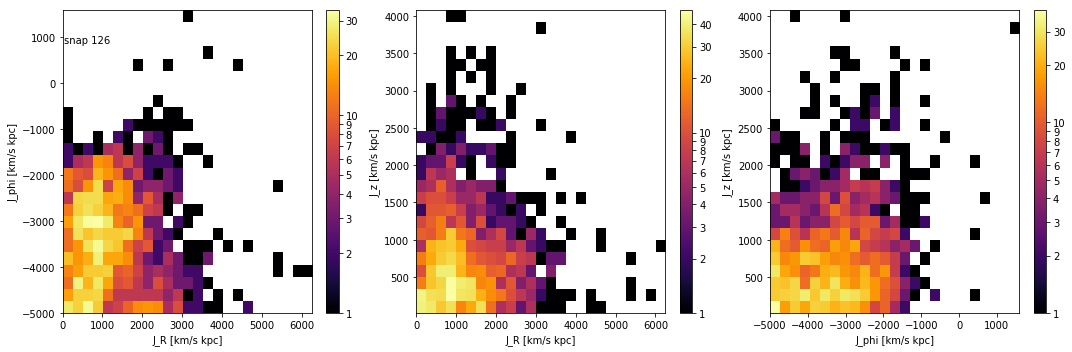

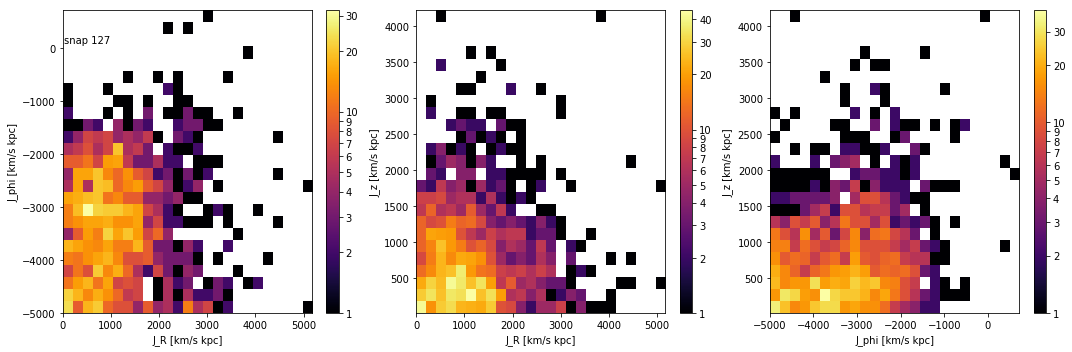

In [17]:
for i in range(70, 128, 1):
    print(i)
    title = 'actions_snap' + str(i)
    infile = '/home/extmilan/masterthesis/files/' + title
    try:
        ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
        print(i)

    except:
        continue
    cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    h1 = ax1.hist2d(jR_kpckms[cond], lz_kpckms[cond], bins = 25, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.inferno)#, \
               #range = [[0, 25], [-25, 25]])
    ax1.set_xlabel("J_R [km/s kpc]")
    ax1.set_ylabel("J_phi [km/s kpc]")
    #ax1.set_xlim(0,15000)
    #ax1.set_ylim(-5000,5000)
    #ax1.legend()
    ax1.text(0.1, 0.9, "snap " + str(i), horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    #ax1.set_aspect('equal')
    #ax1.set_title("mass density")
    divider = make_axes_locatable(ax1)
    try:
        cax1 = divider.append_axes("right", size="5%", pad=0.2)
        cbar1 = fig.colorbar(h1[3], cax=cax1, format = '%d')
    except:
        print("not " + str(i))
        continue
    #cbar1.set_label('$10^{10}\mathrm{M}_\odot\ /\ \mathrm{kpc}^3$')

    h2 = ax2.hist2d(jR_kpckms[cond], jz_kpckms[cond], bins = 25, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.inferno)
    ax2.set_xlabel("J_R [km/s kpc]")
    ax2.set_ylabel("J_z [km/s kpc]")
    #ax2.set_xlim(0,15000)

    #ax2.set_aspect('equal')
    #ax2.set_ylim(0,5000)

    #ax2.set_title('number density')
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.2)
    cbar2 = fig.colorbar(h2[3], cax=cax2, format = '%d')

    h3 = ax3.hist2d(lz_kpckms[cond], jz_kpckms[cond], bins = 25, norm=matplotlib.colors.LogNorm(), cmap = plt.cm.inferno)
    ax3.set_xlabel("J_phi [km/s kpc]")
    ax3.set_ylabel("J_z [km/s kpc]")
    #ax3.set_aspect('equal')
    #ax3.set_xlim(-5000,5000)
    #ax3.set_ylim(0,5000)
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.2)
    cbar3 = fig.colorbar(h3[3], cax=cax3, format = '%d')
    fig.tight_layout()


In [ ]:
def plot_stuff(snap_number):
    infile = '/home/extmilan/masterthesis/files/actions_merger_73_2648_parts_snap_' +str(snap_number)+ '_nonsmoothed_pot_params.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
    cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))    
    H1, xedges1, yedges1 = np.histogram2d(jR_kpckms[cond], lz_kpckms[cond])
    H2, xedges2, yedges2 = np.histogram2d(jR_kpckms[cond], jz_kpckms[cond])
    H3, xedges3, yedges3 = np.histogram2d(lz_kpckms[cond], jz_kpckms[cond])

                #TO DO

s_snap = numpy.arange(73,128,1)

def animate(nframe):
    snap_number = s_snap[nframe]
    print(snap_number)
    plt.cla()
    plt.clf()
    plot_stuff(snap_number)   

    
#fig = plt.figure(figsize=(14, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
line1, = ax1.plot([], [])
line2, = ax2.plot([], [])
line3, = ax3.plot([], [])
line = [line1, line2]
anim = animation.FuncAnimation(fig, animate, frames=len(s_snap))

anim.save('../fig/action_evolution_73_' + str(2648) + '_parts.gif', writer='imagemagick', fps=3)

In [ ]:
def plot_stuff(snap_number):
    infile = '/home/extmilan/masterthesis/files/actions_merger_73_2648_parts_snap_' +str(snap_number)+ '_nonsmoothed_pot_params.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
    cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))    
    data1, xedges1, yedges1 = np.histogram2d(jR_kpckms[cond], lz_kpckms[cond], bins = 151)
    data2, xedges2, yedges2 = np.histogram2d(jR_kpckms[cond], jz_kpckms[cond])
    data3, xedges3, yedges3 = np.histogram2d(lz_kpckms[cond], jz_kpckms[cond])
    return(data1)

    
s_snap = np.arange(73,128,1)
infile = '/home/extmilan/masterthesis/files/actions_merger_73_2648_parts_snap_' + str(73) + '_nonsmoothed_pot_params.txt'
ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)

cond = np.where((jR_kpckms <= 15000.)  & (np.abs(lz_kpckms) <=5000.) & (jz_kpckms <= 5000.))    

X = jR_kpckms[cond]
Y = lz_kpckms[cond]
fig, ax = plt.subplots(figsize = (8,8))

#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 151)
#print(data)
#Smooth with filter
im = ax.imshow(data.T,  cmap=plt.get_cmap('inferno'))#.T .  #, origin = 'lower') #interpolation = 'gaussian', 
time_text = ax.text(0.1, 0.9,'', color = 'red', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(nframe):
    snap_number = s_snap[nframe]
    #print(snap_number)
    #ax.cla()
    #ax.clf()
    data = plot_stuff(snap_number)
    #print(data)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snap_number) )
    

anim = animation.FuncAnimation(fig, animate, frames=len(s_snap))

anim.save('../plots/action_evolution_73_' + str(2648) + '_parts.gif', writer='imagemagick', fps=3)
print('finished')
plt.show()

In [ ]:
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
init = 0
repeater = 1
if init == 0:
    print('starting first figure')
    figure = corner.corner(data.transpose(), labels = labels)#, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
    init +=1
else:
    print('start other figures')
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
#figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

#display(figure)
if repeater == 0:
    print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))

In [ ]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black
norm=matplotlib.colors.LogNorm()
s_snap = np.arange(startnr,endnr,1)

### for xy plot ###
X = x_mergers[0]
Y = y_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



In [ ]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
h = ax.hist2d(rxy2_merg_kpc, z2_merg_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [ ]:
pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
for ID in id_list:    
    gcmask = np.isin(s.id, ID)

    if np.sum(gcmask) == 0:
        continue
    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

    # prepare data for plotting and create corner plot
    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    if init == 0:
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
        init +=1
    else:
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
    #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

    #display(figure)
    if repeater == 0:
        print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))


In [ ]:
s_snap = np.arange(startnr,endnr,1)

fig, ax = plt.subplots(figsize = (8,8))

data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']


figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            

#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

#anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

#anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



In [ ]:
# schau die animationsdokumentation genauer an um zu sehen was ich wann einlesen muss und worueber gelooped werden muss
# entweder save as files oder finde einen anderen weg, wie ich die ids kriege 
def plot_action_corner():
    

In [ ]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*

### ____ fit actions to stars so only load type 4 ____

level = 4

startnr = 72 # nr of snapshot where dwarf is first merged

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startnr,128,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        '''
        if j == 0:
            # initialize figure if not given as input
            j +=1
        else:
        '''

In [ ]:
### write a function out of the routine above
# read in ID lists generated in notebook 2dwarf

#def 

org_dwarfs = ['72']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '72':
            color = 'green' 
            print('Heloohohohohohoheihfhufbe')
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''

In [ ]:
data = np.vstack([R_kpc[r_condition], phi_rad[r_condition], z_kpc[r_condition]])
labels = ['R[kpc]', 'phi[rad]', 'z[kpc]']
corner.corner(data.transpose(), labels = labels, plot_contours = 0, color = color)

ID list done
Potential parameters there
Potential is set up.
Galpy vals gotten.
Action object setup.
actions calculated
Mean value of actions (jR, jphi, jz):  2655.07139881 -366.271656923 1558.55114576

Standard deviation of actions (jR, jphi, jz): 1835.00456425 2036.37253756 1192.77904889
Figure started
ID list done
Potential parameters there
Potential is set up.
Galpy vals gotten.
Action object setup.
actions calculated
Mean value of actions (jR, jphi, jz):  1573.20372618 -5532.89246977 632.49977672

Standard deviation of actions (jR, jphi, jz): 1235.71184032 2122.65783686 518.680776449


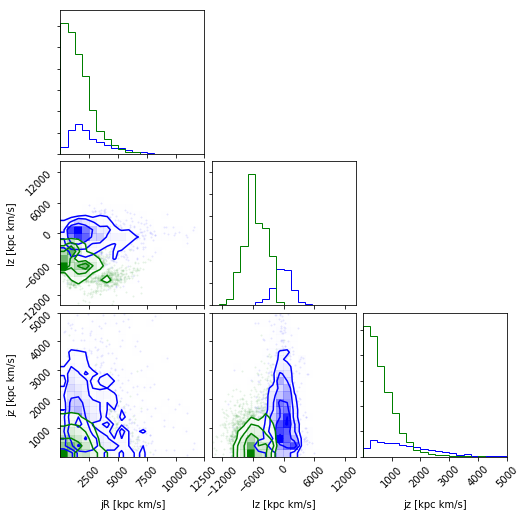

In [18]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['67', '73']
pot_fit_routines = ['emcee1']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids
        print("ID list done")
        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
            print('Potential parameters there')
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms
        # for Snap 127
        v0_kms      = 220.404487902
        a_MND_kpc   = 2.96507719743
        b_MND_kpc   = 1.63627757204
        a_HB_kpc    = 1.71545528287
        a_NFWH_kpc  = 26.1638014798
        v0_MND_kms  = 105.053178361
        v0_HB_kms   = 111.370133355
        v0_NFWH_kms = 158.551762526
        n_MND       = v0_MND_kms**2  / v0_kms**2
        n_HB        = v0_HB_kms**2   / v0_kms**2
        n_NFWH      = v0_NFWH_kms**2 / v0_kms**2
        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        print('Potential is set up.')
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms
            print('Galpy vals gotten.')
            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            print('Action object setup.')
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms
            print('actions calculated')
            print('Mean value of actions (jR, jphi, jz): ', np.mean(jR_kpckms), np.mean(lz_kpckms), np.mean(jz_kpckms))
            print('\nStandard deviation of actions (jR, jphi, jz):', np.std(jR_kpckms), np.std(lz_kpckms), np.std(jz_kpckms))
            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                print('Figure started')
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    #MW potential
    
    
    #data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    #labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    #figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    


In [ ]:
figure.savefig(plotdir + 'fitted_pot_merger_73_vs_104.png', dpi = 300, format = 'png') 

ID list done
Potential parameters there
Potential is set up.
Galpy vals gotten.
Action object setup.
actions calculated
Figure started


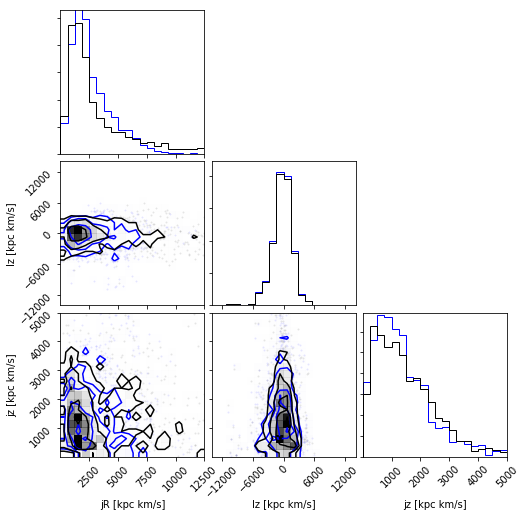

In [19]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['67']
pot_fit_routines = ['emcee1']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids
        print("ID list done")
        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
            print('Potential parameters there')
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        print('Potential is set up.')
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms
            print('Galpy vals gotten.')
            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            print('Action object setup.')
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms
            print('actions calculated')
            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                print('Figure started')
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    #MW potential
    
    infile = '/home/extmilan/masterthesis/files/actions_merger_73_2648_parts_snap_127_MWpot.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
    
#figure.savefig(plotdir + 'fitted_pot_vs_MW_pot_merger_73.png', dpi = 300, format = 'png')    


ID list done
Potential parameters there
Potential is set up.
Galpy vals gotten.
Action object setup.
actions calculated
Figure started


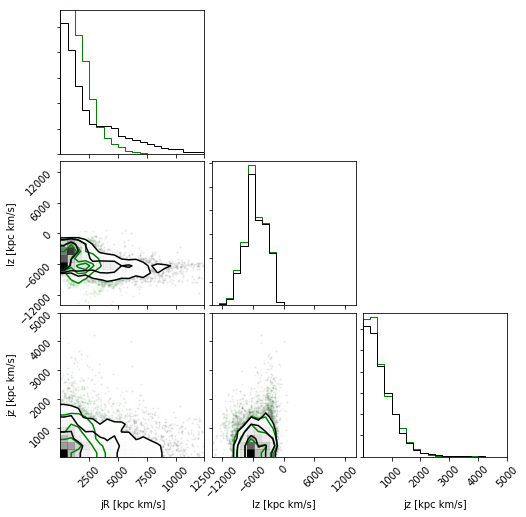

In [20]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['73']
pot_fit_routines = ['emcee1']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '73':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids
        print("ID list done")
        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
            print('Potential parameters there')
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        print('Potential is set up.')
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms
            print('Galpy vals gotten.')
            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            print('Action object setup.')
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms
            print('actions calculated')
            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                print('Figure started')
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    #MW potential
    
    infile = '/home/extmilan/masterthesis/files/actions_merger_104_9785_parts_snap_127_MWpot.txt'
    ids, r, jR_kpckms, lz_kpckms, jz_kpckms = np.loadtxt(infile)
    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
    
    


In [ ]:
#figure.savefig(plotdir + 'fitted_pot_vs_MW_pot_merger_104.png', dpi = 300, format = 'png')